## To build three models:

1. Sentiment analysis model where the stock tweets are to be used to determine the alpha value through text mining.
2. A regression model is to be built using the given stock factors and predict the alpha value for each stock.
3. To build a model using both sentiment analysis and stock factors to get the best results in predicting the stock alpha values.



#### Dataset Description:

* Date: The date when the stock was purchased.	


* SF1 - SF7: The factors that affect the alpha values in each stock.	


* Ticker: The names of the stock that is purchased by the trader.	


* Alpha: The values that define the return of investment and says about the risk factor. Values less than 0 means that the stock is at high risk and the values higher than 0 means that the return of investment is good.

## Exploratory Analysis

### Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import numpy as np
import nltk
import string

import re, unicodedata
from tqdm import tqdm_notebook as tq
from bs4 import BeautifulSoup

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from nltk.corpus import wordnet as wn
from nltk.tokenize.toktok import ToktokTokenizer

import spacy
import en_core_web_sm

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
2

### Reading the JSON data file

In [3]:
import json
import pandas as pd
with open('/content/drive/Mytrain_data.json', 'r') as f:
    df = json.load(f)

In [4]:
## ==> for Train_json
from pandas.io.json import json_normalize

train = pd.concat([pd.DataFrame(df),pd.DataFrame(list(df['records']))],axis=1).drop('records',1)

In [5]:
train.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00


In [6]:
## ==> for Test_json
with open('test_data.json', 'r') as f:
    df_test = json.load(f)

In [7]:
test_json = pd.concat([pd.DataFrame(df_test),pd.DataFrame(list(df_test['records']))],axis=1).drop('records',1)

In [8]:
test_json.head()

,stocktwit_tweet,ticker,timestamp
0,$CELG nothing to be exited about,$CELG,2018-10-25 14:26:16+00:00
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13 13:50:39+00:00
2,$AMD day traders day.,$AMD,2018-09-25 19:10:54+00:00
3,$CBS https://tenor.com/wLB8.gif,$CBS,2018-07-27 22:45:48+00:00
4,$MU weak price action so far today. Don’t be a...,$MU,2018-07-31 14:59:06+00:00


### Checking Shape of JSON file

In [10]:
## ==> for train_json
train.shape

(1039131, 4)

In [11]:
## for Test_json
test_json.shape

(265022, 3)

In [12]:
## ==> for train_json
train.dtypes

stocktwit_tweet    object
sentiment_score     int64
timestamp          object
ticker             object
dtype: object

In [13]:
## ==> for Test_json
test_json.dtypes

stocktwit_tweet    object
timestamp          object
ticker             object
dtype: object

 ### Changing the " ticker " Column in json file

In [0]:
## ==> for Train_json

train['ticker']=train['ticker'].str.replace('$','')
train['ticker']=train['ticker'].str.upper()

In [15]:
train.head()

,stocktwit_tweet,sentiment_score,timestamp,ticker
0,$AMD going up but hesitating however chart is ...,3,2018-09-19 18:38:28+00:00,AMD
1,@inforlong @MariaGascon Despite\nChina trade w...,3,2018-10-09 03:51:06+00:00,CAT
2,$AVGO WTF?,2,2018-07-12 13:35:32+00:00,AVGO
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,2018-07-19 03:32:50+00:00,PH
4,$FB if it bounces tommorrow do the right thing...,3,2018-08-23 19:07:54+00:00,FB


In [0]:
## ==> for Test_json

test_json['ticker'] = test_json['ticker'].str.replace('$','')
test_json['ticker'] = test_json['ticker'].str.upper()

In [17]:
test_json.head()

,stocktwit_tweet,timestamp,ticker
0,$CELG nothing to be exited about,2018-10-25 14:26:16+00:00,CELG
1,$AMD yall exhaust your buyer on first green ca...,2018-07-13 13:50:39+00:00,AMD
2,$AMD day traders day.,2018-09-25 19:10:54+00:00,AMD
3,$CBS https://tenor.com/wLB8.gif,2018-07-27 22:45:48+00:00,CBS
4,$MU weak price action so far today. Don’t be a...,2018-07-31 14:59:06+00:00,MU


### Checking the Tweets with respect to Score

In [18]:
train[train['sentiment_score']==0].head()

,stocktwit_tweet,sentiment_score,timestamp,ticker
5,$FB as usual......RED \nevery day.,0,2018-08-02 11:40:49+00:00,FB
17,"$mu mms took out the SLs, yet it still won&#39...",0,2018-09-05 14:23:16+00:00,MU
25,$MSFT short the high. easy flip,0,2018-07-12 18:13:49+00:00,MSFT
31,$NFLX Astonishing crash for NFLX by late next ...,0,2018-10-07 02:53:29+00:00,NFLX
37,$MU It is the best time to leave within 15 min...,0,2018-07-04 20:35:58+00:00,MU


In [19]:
train[train['sentiment_score']==1].head()

,stocktwit_tweet,sentiment_score,timestamp,ticker
20,$MU you all know that when it drops in one day...,1,2018-09-06 19:32:52+00:00,MU
24,$NFLX Looks like this resistance will be broke...,1,2018-09-26 16:34:10+00:00,NFLX
29,$GE going red today,1,2018-07-20 11:14:35+00:00,GE
33,"$FB For my stupid fb bull friends, hehehe, \...",1,2018-07-26 13:19:12+00:00,FB
39,$AMD analysts on Estimize expect 7.61% YoY gro...,1,2018-09-06 12:36:09+00:00,AMD


In [20]:
train[train['sentiment_score']==2].head()

,stocktwit_tweet,sentiment_score,timestamp,ticker
2,$AVGO WTF?,2,2018-07-12 13:35:32+00:00,AVGO
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,2018-07-19 03:32:50+00:00,PH
6,$AET UnitedHealth Group Goes Ex-Dividend Today...,2,2018-09-07 15:01:06+00:00,AET
8,@InCyD3R @Ferrabi I bet you’re also the one sa...,2,2018-10-28 01:19:27+00:00,AMZN
9,$AMD Pastor the Stooge,2,2018-08-17 13:35:00+00:00,AMD


In [21]:
train[train['sentiment_score']==3].head()

,stocktwit_tweet,sentiment_score,timestamp,ticker
0,$AMD going up but hesitating however chart is ...,3,2018-09-19 18:38:28+00:00,AMD
1,@inforlong @MariaGascon Despite\nChina trade w...,3,2018-10-09 03:51:06+00:00,CAT
4,$FB if it bounces tommorrow do the right thing...,3,2018-08-23 19:07:54+00:00,FB
19,$MU 5 min chart you can see Where the long ter...,3,2018-08-09 14:09:52+00:00,MU
36,$AMD Good luck to everyone that holds.,3,2018-10-24 19:52:13+00:00,AMD


In [22]:
train[train['sentiment_score']==4].head()

,stocktwit_tweet,sentiment_score,timestamp,ticker
7,$NOC let&#39;s see when we can hit 310,4,2018-09-12 20:48:40+00:00,NOC
16,$AMD buying more,4,2018-09-18 15:45:22+00:00,AMD
22,$MU doesn’t miss MU Long Rally (Bullish),4,2018-07-24 08:53:28+00:00,MU
26,"$AMZN $3000 Target,",4,2018-09-04 14:12:54+00:00,AMZN
42,#Update(4) $COST Jul-27 220 Calls Up +25%. 1...,4,2018-07-24 13:50:53+00:00,COST


### Changing the timestamp column as month & day

In [23]:
## ==> for Train_json

train['timestamp'] = train['timestamp'].str.split(' ').str[0]
train['month'] = train['timestamp'].str.split('-', expand = True)[1]
train['day'] = train['timestamp'].str.split('-',expand = True)[2]

train.head()

,stocktwit_tweet,sentiment_score,timestamp,ticker,month,day
0,$AMD going up but hesitating however chart is ...,3,2018-09-19,AMD,09,19
1,@inforlong @MariaGascon Despite\nChina trade w...,3,2018-10-09,CAT,10,09
2,$AVGO WTF?,2,2018-07-12,AVGO,07,12
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,2018-07-19,PH,07,19
4,$FB if it bounces tommorrow do the right thing...,3,2018-08-23,FB,08,23


In [24]:
## ==> for Test_json

test_json['timestamp'] = test_json['timestamp'].str.split(' ').str[0]
test_json['month'] = test_json['timestamp'].str.split('-', expand = True)[1]
test_json['day'] = test_json['timestamp'].str.split('-',expand = True)[2]

test_json.head(4)

,stocktwit_tweet,timestamp,ticker,month,day
0,$CELG nothing to be exited about,2018-10-25,CELG,10,25
1,$AMD yall exhaust your buyer on first green ca...,2018-07-13,AMD,07,13
2,$AMD day traders day.,2018-09-25,AMD,09,25
3,$CBS https://tenor.com/wLB8.gif,2018-07-27,CBS,07,27


### Changing the DataTypes in JSON file

In [0]:
## ==> for Train_json
for i in ['stocktwit_tweet','sentiment_score','ticker','month','day']:
    train[i] = train[i].astype('category')

In [26]:
train.dtypes

stocktwit_tweet    category
sentiment_score    category
timestamp            object
ticker             category
month              category
day                category
dtype: object

In [0]:
## ==> for Test_json
for i in ['stocktwit_tweet','ticker','month','day']:
  test_json[i] = test_json[i].astype('category')

In [28]:
test_json.dtypes

stocktwit_tweet    category
timestamp            object
ticker             category
month              category
day                category
dtype: object

### Removing the Unnecessary columns in JSON file

In [29]:
## ==> for train_json
train.drop('timestamp', axis=1,inplace=True)
train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09
2,$AVGO WTF?,2,AVGO,07,12
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23


In [30]:
train.dtypes

stocktwit_tweet    category
sentiment_score    category
ticker             category
month              category
day                category
dtype: object

In [31]:
## ==> for test_json
test_json.drop('timestamp', axis=1,inplace=True)
test_json.head()

,stocktwit_tweet,ticker,month,day
0,$CELG nothing to be exited about,CELG,10,25
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13
2,$AMD day traders day.,AMD,09,25
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27
4,$MU weak price action so far today. Don’t be a...,MU,07,31


In [32]:
test_json.dtypes

stocktwit_tweet    category
ticker             category
month              category
day                category
dtype: object

### Describing the Data in JSON file

In [33]:
## ==> for Train_json
train.describe()

,stocktwit_tweet,sentiment_score,ticker,month,day
count,1039131,1039131,1039131,1039131,1039131
unique,959608,5,1530,4,31
top,$AMD,2,AMD,10,25
freq,2474,464402,165784,274333,52135


In [34]:
## ==> for Test_json
test_json.describe()

,stocktwit_tweet,ticker,month,day
count,265022,265022,265022,265022
unique,252890,968,4,31
top,$AMD,AMD,10,25
freq,622,42677,69935,13358


## Cleaning the Tweets data

In [0]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [40]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
nlp = spacy.load('en', parse = False, tag=False, entity=False)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

### Converting the emoji's to words

In [42]:
!pip install emoji

In [43]:
import emoji
## ==> for Train_json
train['Cleaned_data'] = train['stocktwit_tweet'].apply(lambda x: emoji.demojize(x))

train['Cleaned_data'] = train['Cleaned_data'].str.replace(":", "",regex=False)
train['Cleaned_data'] = train['Cleaned_data'].str.replace("_", " ",regex=False)

train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,$AMD going up but hesitating however chart is ...
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,@inforlong @MariaGascon Despite\nChina trade w...
2,$AVGO WTF?,2,AVGO,07,12,$AVGO WTF?
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,$PH\n New Insider Filing On \n MULLER KLAUS PE...
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,$FB if it bounces tommorrow do the right thing...


In [44]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['stocktwit_tweet'].apply(lambda x: emoji.demojize(x))

test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace(":", "",regex=False)
test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace("_", " ",regex=False)

test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$CELG nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$AMD yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$AMD day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$CBS https//tenor.com/wLB8.gif
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$MU weak price action so far today. Don’t be a...


### Removing "http" & "WWW" links

In [45]:
## ==>for Train_json
train['Cleaned_data'] = train['Cleaned_data'].str.replace('http\S*|www.\S*','', case=False)
train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,$AMD going up but hesitating however chart is ...
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,@inforlong @MariaGascon Despite\nChina trade w...
2,$AVGO WTF?,2,AVGO,07,12,$AVGO WTF?
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,$PH\n New Insider Filing On \n MULLER KLAUS PE...
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,$FB if it bounces tommorrow do the right thing...


In [46]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace('http\S*|www.\S*','', case=False)
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$CELG nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$AMD yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$AMD day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$CBS
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$MU weak price action so far today. Don’t be a...


### Removing "@" from tweets

In [47]:
## ==> for Train_json
train['Cleaned_data'] = train['Cleaned_data'].str.replace("@[\w]*","")

train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,$AMD going up but hesitating however chart is ...
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,Despite\nChina trade war $CAT held very well...
2,$AVGO WTF?,2,AVGO,07,12,$AVGO WTF?
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,$PH\n New Insider Filing On \n MULLER KLAUS PE...
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,$FB if it bounces tommorrow do the right thing...


In [48]:
## for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace("@[\w]*","")

test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$CELG nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$AMD yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$AMD day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$CBS
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$MU weak price action so far today. Don’t be a...


### Removing Accented Chars from Tweet

In [0]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [50]:
## ==> for Train_json
train['Cleaned_data'] = train['Cleaned_data'].apply(remove_accented_chars)
train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,$AMD going up but hesitating however chart is ...
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,Despite\nChina trade war $CAT held very well...
2,$AVGO WTF?,2,AVGO,07,12,$AVGO WTF?
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,$PH\n New Insider Filing On \n MULLER KLAUS PE...
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,$FB if it bounces tommorrow do the right thing...


In [51]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].apply(remove_accented_chars)
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$CELG nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$AMD yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$AMD day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$CBS
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$MU weak price action so far today. Dont be af...


### converting the text to lower case

In [52]:
## ==>for Train_json
train['Cleaned_data']=train['Cleaned_data'].str.lower()
train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,$amd going up but hesitating however chart is ...
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,despite\nchina trade war $cat held very well...
2,$AVGO WTF?,2,AVGO,07,12,$avgo wtf?
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,$ph\n new insider filing on \n muller klaus pe...
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,$fb if it bounces tommorrow do the right thing...


In [53]:
## ==> for Test_json
test_json['Cleaned_data']=test_json['Cleaned_data'].str.lower()
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$celg nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$amd yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$amd day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$cbs
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$mu weak price action so far today. dont be af...


### Removing the empty space in tweets

In [0]:
## ==> for Train_json
emptytweets1 = train[['stocktwit_tweet','ticker']].apply(lambda row: (len(row['stocktwit_tweet'])-len(row['ticker']) ==0), axis=1)

emptytweets = train[emptytweets1]

In [55]:
emptytweets.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data


In [0]:
train = train[-emptytweets1]

In [57]:
train['Cleaned_data'][1:15]

1       despite\nchina trade war $cat held very well...
2                                            $avgo wtf?
3     $ph\n new insider filing on \n muller klaus pe...
4     $fb if it bounces tommorrow do the right thing...
5                   $fb as usual......red  \nevery day.
6     $aet unitedhealth group goes ex-dividend today...
7                $noc let&#39;s see when we can hit 310
8       i bet youre also the one saying $amzn should...
9                                $amd pastor the stooge
10    $nflx called it friday hahahaha suckers sold f...
11    $gww exp7/20/2018|maxpain292.5|highputoi250.0(...
12    $nflx day in, day out this puppy is making peo...
13                                                $aapl
14                                                $antm
Name: Cleaned_data, dtype: object

In [0]:
## ==> for Test_json
emptytweets2 = test_json[['stocktwit_tweet','ticker']].apply(lambda row: (len(row['stocktwit_tweet'])-len(row['ticker']) ==0), axis=1)

test_emptytweets = test_json[emptytweets2]

In [59]:
test_emptytweets.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data


In [0]:
test_json = test_json[-emptytweets2]

In [61]:
test_json['Cleaned_data'][1:15]

1     $amd yall exhaust your buyer on first green ca...
2                                 $amd day traders day.
3                                                 $cbs 
4     $mu weak price action so far today. dont be af...
5     $amzn continues to grow, specifically in key a...
6     $clf if you are not loading up right now, you ...
7     $mu crap shoot. legit no one knows if its goin...
8     $amd how does this chart look like a setup for...
9           $amd amd is like my sex life. its so dry rn
10    $amd finally amd got its anti-gravity technolo...
11    $syf seems like a lot of todo to halt with 30 ...
12    $fb you know mark has been dumping more shares...
13    $nke remember this trumppalo boycott? aapl was...
14    $alxn positioning changed significantly over t...
Name: Cleaned_data, dtype: object

### Removing "dollarsign" from Tweet

In [62]:
## ==> for Train_json
train['Cleaned_data']=train['Cleaned_data'].str.replace("\$[\w]*","")
train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,going up but hesitating however chart is very...
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,despite\nchina trade war held very well thu...
2,$AVGO WTF?,2,AVGO,07,12,wtf?
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,\n new insider filing on \n muller klaus peter...
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,if it bounces tommorrow do the right thing an...


In [63]:
## ==> for Test_json
test_json['Cleaned_data']=test_json['Cleaned_data'].str.replace("\$[\w]*","")
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,yall exhaust your buyer on first green candle...
2,$AMD day traders day.,AMD,09,25,day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,
4,$MU weak price action so far today. Don’t be a...,MU,07,31,weak price action so far today. dont be afrai...


### Removing Repeating Words in Tweet

In [64]:
## ==> for Train_json
train['Cleaned_data'] = train['Cleaned_data'].apply(lambda x : re.sub(r'(.)\1{1,}', r'\1\1', x) )
train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,going up but hesitating however chart is very...
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,despite\nchina trade war held very well thu...
2,$AVGO WTF?,2,AVGO,07,12,wtf?
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,\n new insider filing on \n muller klaus peter...
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,if it bounces tommorrow do the right thing an...


In [65]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].apply(lambda x : re.sub(r'(.)\1{1,}', r'\1\1', x) )
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,yall exhaust your buyer on first green candle...
2,$AMD day traders day.,AMD,09,25,day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,
4,$MU weak price action so far today. Don’t be a...,MU,07,31,weak price action so far today. dont be afrai...


### Removing Special Characters,Punctuations, Numbers and Unnecessary Hashtags in tweets

In [66]:
## ==> for train_json
train['Cleaned_data'] = train['Cleaned_data'].str.replace("[^a-zA-Z]", " ")
train['Cleaned_data'] = train['Cleaned_data'].str.replace("[#+]?\B", "")
train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,going up but hesitating however chart is very...
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,despite china trade war held very well thum...
2,$AVGO WTF?,2,AVGO,07,12,wtf
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,new insider filing on muller klaus peter t...
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,if it bounces tommorrow do the right thing an...


In [67]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace("[^a-zA-Z]", " ")
test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace("[#+]?\B", "")
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,yall exhaust your buyer on first green candle...
2,$AMD day traders day.,AMD,09,25,day traders day
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,
4,$MU weak price action so far today. Don’t be a...,MU,07,31,weak price action so far today dont be afrai...


### Expanding Contractions

In [0]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [69]:
## ==> Train_json
train['Cleaned_data'] = train['Cleaned_data'].apply(expand_contractions)
train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,going up but hesitating however chart is very...
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,despite china trade war held very well thum...
2,$AVGO WTF?,2,AVGO,07,12,wtf
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,new insider filing on muller klaus peter t...
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,if it bounces tommorrow do the right thing an...


In [70]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].apply(expand_contractions)
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,yall exhaust your buyer on first green candle...
2,$AMD day traders day.,AMD,09,25,day traders day
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,
4,$MU weak price action so far today. Don’t be a...,MU,07,31,weak price action so far today dont be afrai...


### Removing the Stopwords in tweets

In [0]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [72]:
## ==> for train_json
train['Cleaned_data'] = train['Cleaned_data'].apply(remove_stopwords)
train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,going hesitating however chart stable going up...
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,despite china trade war held well thumbs
2,$AVGO WTF?,2,AVGO,07,12,wtf
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,new insider filing muller klaus peter transact...
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,bounces tommorrow right thing gtfo


In [73]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].apply(remove_stopwords)
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,nothing exited
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,yall exhaust buyer first green candle byee
2,$AMD day traders day.,AMD,09,25,day traders day
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,
4,$MU weak price action so far today. Don’t be a...,MU,07,31,weak price action far today dont afraid go sho...


In [74]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Tokenizing the Cleaned_data

In [0]:
## ==> for Train_json
token_text = []

for i in train['Cleaned_data']:
    token_text.append(word_tokenize(i))
    
train['Processed_data'] = token_text

In [77]:
train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data,Processed_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,going hesitating however chart stable going up...,"[going, hesitating, however, chart, stable, go..."
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,despite china trade war held well thumbs,"[despite, china, trade, war, held, well, thumbs]"
2,$AVGO WTF?,2,AVGO,07,12,wtf,[wtf]
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,new insider filing muller klaus peter transact...,"[new, insider, filing, muller, klaus, peter, t..."
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,bounces tommorrow right thing gtfo,"[bounces, tommorrow, right, thing, gtfo]"


In [0]:
## ==> for Test_json
token_text_test = []

for i in test_json['Cleaned_data']:
    token_text_test.append(word_tokenize(i))
    
test_json['Processed_data'] = token_text_test

In [79]:
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data,Processed_data
0,$CELG nothing to be exited about,CELG,10,25,nothing exited,"[nothing, exited]"
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,yall exhaust buyer first green candle byee,"[yall, exhaust, buyer, first, green, candle, b..."
2,$AMD day traders day.,AMD,09,25,day traders day,"[day, traders, day]"
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,,[]
4,$MU weak price action so far today. Don’t be a...,MU,07,31,weak price action far today dont afraid go sho...,"[weak, price, action, far, today, dont, afraid..."


### Lemmatizing the Text data

In [80]:
## ==> for Train_json
lemmatizer = WordNetLemmatizer()

train['Processed_data'] = train['Processed_data'].apply(lambda x: [lemmatizer.lemmatize(y,pos = 'v') for y in x])

train.head()

,stocktwit_tweet,sentiment_score,ticker,month,day,Cleaned_data,Processed_data
0,$AMD going up but hesitating however chart is ...,3,AMD,09,19,going hesitating however chart stable going up...,"[go, hesitate, however, chart, stable, go, upw..."
1,@inforlong @MariaGascon Despite\nChina trade w...,3,CAT,10,09,despite china trade war held well thumbs,"[despite, china, trade, war, hold, well, thumb]"
2,$AVGO WTF?,2,AVGO,07,12,wtf,[wtf]
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,PH,07,19,new insider filing muller klaus peter transact...,"[new, insider, file, muller, klaus, peter, tra..."
4,$FB if it bounces tommorrow do the right thing...,3,FB,08,23,bounces tommorrow right thing gtfo,"[bounce, tommorrow, right, thing, gtfo]"


In [81]:
## ==> for Test_json

test_json['Processed_data'] = test_json['Processed_data'].apply(lambda x: [lemmatizer.lemmatize(y,pos = 'v') for y in x])

test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data,Processed_data
0,$CELG nothing to be exited about,CELG,10,25,nothing exited,"[nothing, exit]"
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,yall exhaust buyer first green candle byee,"[yall, exhaust, buyer, first, green, candle, b..."
2,$AMD day traders day.,AMD,09,25,day traders day,"[day, traders, day]"
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,,[]
4,$MU weak price action so far today. Don’t be a...,MU,07,31,weak price action far today dont afraid go sho...,"[weak, price, action, far, today, dont, afraid..."


### Converting the Tokenized words into normal words

In [0]:
## ==> for Train_json
train['Processed_data'] = train['Processed_data'].apply(lambda x: ' '.join(x))

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1039131 entries, 0 to 1039130
Data columns (total 7 columns):
stocktwit_tweet    1039131 non-null category
sentiment_score    1039131 non-null category
ticker             1039131 non-null category
month              1039131 non-null category
day                1039131 non-null category
Cleaned_data       1039131 non-null object
Processed_data     1039131 non-null object
dtypes: category(5), object(2)
memory usage: 80.1+ MB


In [0]:
## ==> for Test_json
test_json['Processed_data'] = test_json['Processed_data'].apply(lambda x: ' '.join(x))

In [85]:
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data,Processed_data
0,$CELG nothing to be exited about,CELG,10,25,nothing exited,nothing exit
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,yall exhaust buyer first green candle byee,yall exhaust buyer first green candle byee
2,$AMD day traders day.,AMD,09,25,day traders day,day traders day
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,,
4,$MU weak price action so far today. Don’t be a...,MU,07,31,weak price action far today dont afraid go sho...,weak price action far today dont afraid go sho...


In [86]:
test_json.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265022 entries, 0 to 265021
Data columns (total 6 columns):
stocktwit_tweet    265022 non-null category
ticker             265022 non-null category
month              265022 non-null category
day                265022 non-null category
Cleaned_data       265022 non-null object
Processed_data     265022 non-null object
dtypes: category(4), object(2)
memory usage: 20.1+ MB


In [0]:
test_json['Processed_data'] = test_json['Processed_data'].astype('category')

### WordCloud to Visualize the Word Frequency

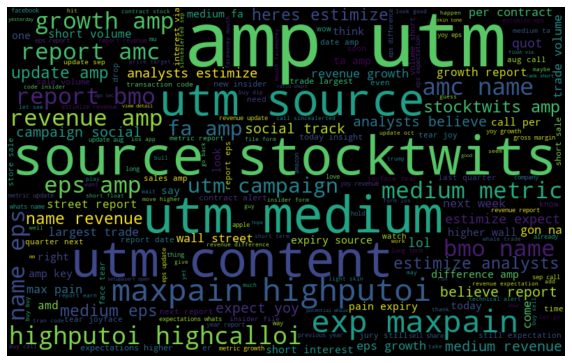

CPU times: user 34.2 s, sys: 3.53 s, total: 37.8 s
Wall time: 37.9 s


In [88]:
%%time
all_words = ' '.join([text for text in train['Processed_data']])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Splitting the Train & test in Json File

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X = train['Processed_data']
Y = train['sentiment_score']

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [0]:
x_train_json, x_test_json, y_train_json, y_test_json = train_test_split(X, Y,test_size=0.3, random_state=123)

In [0]:
x_train_json = cv.fit_transform(x_train_json)
x_test_json = cv.transform(x_test_json)

In [0]:
Test_data = test_json['Processed_data']
Vectorized_test_data = cv.transform(Test_data)

### Model Building

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,cross_val_score

In [0]:
log_reg = LogisticRegression(penalty='l2')

In [0]:
param_grid = {'C': [0.001, 0.01, 0.1] }
Logistic_model = GridSearchCV(log_reg, param_grid, cv=5,verbose=1, n_jobs=-1)

In [98]:
Logistic_model.fit(x_train_json,y_train_json)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 12.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [99]:
train_json_pred = Logistic_model.predict(x_train_json)
test_json_pred = Logistic_model.predict(x_test_json)

print(Logistic_model.score(x_train_json, y_train_json))
print(Logistic_model.score(x_test_json, y_test_json))

0.6450258526707094
0.6365079874254186


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [101]:
print(f1_score(y_true=y_train_json, y_pred=train_json_pred, average=None))
print(classification_report(y_true=y_train_json, y_pred=train_json_pred))

[0.58444691 0.43358466 0.75909474 0.44443602 0.62215567]
              precision    recall  f1-score   support

           0       0.67      0.52      0.58     64636
           1       0.60      0.34      0.43     84365
           2       0.66      0.89      0.76    325086
           3       0.58      0.36      0.44    145667
           4       0.65      0.59      0.62    107637

    accuracy                           0.65    727391
   macro avg       0.63      0.54      0.57    727391
weighted avg       0.64      0.65      0.62    727391



In [102]:
print(f1_score(y_true=y_test_json, y_pred=test_json_pred, average=None))
print(classification_report(y_true=y_test_json, y_pred=test_json_pred))

[0.57264273 0.41808149 0.7543714  0.42965589 0.61054908]
              precision    recall  f1-score   support

           0       0.65      0.51      0.57     27386
           1       0.59      0.32      0.42     36406
           2       0.65      0.89      0.75    139316
           3       0.56      0.35      0.43     62364
           4       0.64      0.58      0.61     46268

    accuracy                           0.64    311740
   macro avg       0.62      0.53      0.56    311740
weighted avg       0.63      0.64      0.61    311740



In [103]:
test_json_Predictions = Logistic_model.predict(Vectorized_test_data)
test_json_Predictions

array([2, 4, 2, ..., 2, 2, 4])

In [104]:
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data,Processed_data
0,$CELG nothing to be exited about,CELG,10,25,nothing exited,nothing exit
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,yall exhaust buyer first green candle byee,yall exhaust buyer first green candle byee
2,$AMD day traders day.,AMD,09,25,day traders day,day traders day
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,,
4,$MU weak price action so far today. Don’t be a...,MU,07,31,weak price action far today dont afraid go sho...,weak price action far today dont afraid go sho...


# Reading the CSV File

#### Importing Libraries

In [0]:
import os
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [0]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier


#### Reading the CSV data file

In [0]:
## ==> Train_data
data = pd.read_csv("/content/drive/My Drive/DATASET/train_factors.csv")

In [0]:
## ==> Test_data
test = pd.read_csv("/content/drive/My Drive/DATASET/test_factors.csv")

#### Checking the Shape of the CSV file

In [109]:
data.shape

(27006, 11)

In [110]:
data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,10/07/18,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,12/09/18,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [111]:
data.dtypes

Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
alpha       int64
dtype: object

In [112]:
test.shape

(11575, 10)

In [113]:
test.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,21/07/18,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,05/10/18,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,01/10/18,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,24/10/18,$CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,27/07/18,$intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


In [114]:
test.dtypes

Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
dtype: object

#### Changing the "ticker" & "date" Column in csv file

In [115]:
## ==> for Train_data
data["ticker"] = data["ticker"].str.replace('$','')
data["ticker"] = data["ticker"].str.upper()
data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,21/08/18,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,11/10/18,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,21/08/18,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,10/07/18,GE,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,12/09/18,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [116]:
data['month'] = data['date'].str.split('/', expand = True)[1]
data['day'] = data['date'].str.split('/',expand = True)[0]

data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,month,day
0,1,21/08/18,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,08,21
1,2,11/10/18,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,10,11
2,3,21/08/18,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,08,21
3,4,10/07/18,GE,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,07,10
4,5,12/09/18,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,09,12


In [117]:
data.dtypes

Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
alpha       int64
month      object
day        object
dtype: object

In [118]:
## ==> for Test_data
test['ticker'] = test['ticker'].str.replace('$','')
test['ticker'] = test['ticker'].str.upper()

test.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,21/07/18,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,05/10/18,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,01/10/18,CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,24/10/18,CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,27/07/18,INTC,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


In [119]:
test['month'] = test['date'].str.split('/', expand = True)[1]
test['day'] = test['date'].str.split('/',expand = True)[0]

test.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,month,day
0,270007,21/07/18,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,07,21
1,270008,05/10/18,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,10,05
2,270009,01/10/18,CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,10,01
3,270010,24/10/18,CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,10,24
4,270011,27/07/18,INTC,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,07,27


In [120]:
test.dtypes

Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
month      object
day        object
dtype: object

#### Changing the DataTypes in CSV file

In [0]:
## ==> for Train_data
for i in ['ticker','alpha','month','day']:
    data[i] = data[i].astype('category')

In [122]:
data.dtypes

Id           int64
date        object
ticker    category
SF1        float64
SF2        float64
SF3        float64
SF4        float64
SF5        float64
SF6        float64
SF7        float64
alpha     category
month     category
day       category
dtype: object

In [0]:
## ==> for Test_data
for i in ['ticker','month','day']:
  test[i] = test[i].astype('category')

In [124]:
test.dtypes

Id           int64
date        object
ticker    category
SF1        float64
SF2        float64
SF3        float64
SF4        float64
SF5        float64
SF6        float64
SF7        float64
month     category
day       category
dtype: object

#### Droping Unnecessary columns in CSV file

In [125]:
## ==> for train_data
data.drop(['Id','date'], axis=1, inplace= True)
data.head()

,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,month,day
0,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,08,21
1,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,10,11
2,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,08,21
3,GE,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,07,10
4,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,09,12


In [126]:
## ==> for Test_data
test.drop(['Id','date'], axis=1, inplace= True)
test.head()

,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,month,day
0,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,07,21
1,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,10,05
2,CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,10,01
3,CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,10,24
4,INTC,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,07,27


#### Decsribeing the Data in CSV file

In [127]:
data.describe()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7
count,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000
mean,0.005429,-0.001005,-0.024421,-0.042420,0.041465,0.002597,0.036744
std,0.941853,0.996130,0.539555,1.111309,0.976028,0.998839,1.204473
min,-4.114670,-4.578587,-2.609150,-6.329798,-5.480268,-4.338751,-5.347869
25%,-0.596792,-0.666310,-0.300187,-0.767247,-0.518641,-0.668027,-0.688198
50%,0.012104,-0.013257,-0.040786,-0.058629,0.072127,0.007417,0.081374
75%,0.611574,0.669094,0.241424,0.677433,0.616538,0.674592,0.807556
max,4.415048,3.822270,3.452486,4.907407,4.779911,4.075428,5.182912


In [128]:
data.describe(include='category')

,ticker,alpha,month,day
count,27006,27006,27006,27006
unique,872,4,4,31
top,MU,2,08,17
freq,156,10912,7099,1040


In [129]:
test.describe()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7
count,11575.000000,11575.000000,11575.000000,11575.000000,11575.000000,11575.000000,11575.000000
mean,0.001546,0.003995,-0.029754,-0.047606,0.053956,-0.000428,0.037914
std,0.924519,0.997903,0.537651,1.097842,0.965109,1.003503,1.192223
min,-4.130410,-4.034445,-4.259227,-4.704038,-4.545787,-4.317883,-5.031257
25%,-0.580470,-0.673206,-0.308838,-0.754051,-0.502280,-0.682896,-0.684029
50%,0.011865,-0.001464,-0.044590,-0.055108,0.084598,0.008303,0.081955
75%,0.600965,0.685805,0.228484,0.649046,0.620426,0.680800,0.807105
max,4.519223,4.108285,2.763214,4.794511,5.646556,3.900014,6.005315


In [130]:
test.describe(include='category')

,ticker,month,day
count,11575,11575,11575
unique,716,4,31
top,AMD,08,17
freq,73,3028,473


#### Checking the NULL values

In [131]:
data.isnull().sum()

ticker    0
SF1       0
SF2       0
SF3       0
SF4       0
SF5       0
SF6       0
SF7       0
alpha     0
month     0
day       0
dtype: int64

In [132]:
test.isnull().sum()

ticker    0
SF1       0
SF2       0
SF3       0
SF4       0
SF5       0
SF6       0
SF7       0
month     0
day       0
dtype: int64

### Spliting the data as Train & Test

In [0]:
X = data.drop('alpha', axis = 1)
Y = data['alpha']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123)

In [141]:
print(x_train.shape)
print(y_train.shape,'\n')

print(x_test.shape)
print(y_test.shape)

(18904, 10)
(18904,) 

(8102, 10)
(8102,)


#### Spliting Numeric and Categorical Columns

In [142]:
num_attr = x_train.select_dtypes(['int64','float64']).columns
num_attr

Index(['SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7'], dtype='object')

In [143]:
cat_attr = x_train.select_dtypes('category').columns
cat_attr

Index(['ticker', 'month', 'day'], dtype='object')

#### Standardization for Numerical variables

In [0]:
scaler = StandardScaler()
scaler.fit(x_train[num_attr])

x_train[num_attr]=scaler.transform(x_train[num_attr])
x_test[num_attr]=scaler.transform(x_test[num_attr])

In [145]:
x_train.head()

,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,month,day
21056,BA,0.429948,0.569472,-0.598065,-0.066687,0.378638,-0.226901,0.403420,10,03
17272,GT,-0.471291,0.139552,0.242308,-0.150186,0.014662,-1.744976,-0.268657,07,29
18342,ABBV,0.639123,0.293121,-0.057967,-1.277659,-0.415831,0.347895,1.147703,10,12
24702,SYF,-2.010654,-0.925851,1.854148,1.265319,-0.687534,0.736085,-2.296924,10,06
20574,BHF,0.978297,0.653474,0.906889,0.752397,-1.518995,-1.315938,0.142554,08,10


In [146]:
x_test.head()

,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,month,day
2032,CAT,-0.738787,-1.796427,1.518200,-1.001561,-1.257883,-1.364324,-0.137966,08,05
19907,F,1.244399,-0.001350,-0.929974,-0.056632,0.242156,1.910303,0.994589,09,19
26615,EMR,-0.412405,0.870813,-0.091893,0.251169,0.367333,-0.571985,-0.408822,10,03
4396,SYK,-1.014965,1.025701,2.241092,-1.133659,-1.878495,-0.943579,-0.342073,10,18
7095,GME,2.639051,0.530865,-3.132901,-1.568206,1.662608,1.351205,3.049206,08,28


In [0]:
## Droping the Ticker for Model Building Purpose
x_train.drop('ticker', axis=1,inplace=True)
x_test.drop('ticker',axis=1,inplace=True)

In [148]:
x_train.head(3)

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,month,day
21056,0.429948,0.569472,-0.598065,-0.066687,0.378638,-0.226901,0.403420,10,03
17272,-0.471291,0.139552,0.242308,-0.150186,0.014662,-1.744976,-0.268657,07,29
18342,0.639123,0.293121,-0.057967,-1.277659,-0.415831,0.347895,1.147703,10,12


In [149]:
x_test.head(3)

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,month,day
2032,-0.738787,-1.796427,1.518200,-1.001561,-1.257883,-1.364324,-0.137966,08,05
19907,1.244399,-0.001350,-0.929974,-0.056632,0.242156,1.910303,0.994589,09,19
26615,-0.412405,0.870813,-0.091893,0.251169,0.367333,-0.571985,-0.408822,10,03


## Model Building

In [0]:
dt = DecisionTreeClassifier()

In [151]:
dt_param = {'criterion': ['entropy', 'gini'],
                     'max_depth': [12,15,16,17],
                     "min_samples_split": [5,15,17],
                     "min_samples_leaf": [5,6,7 ,10]}

Decision = GridSearchCV(dt, param_grid = dt_param, cv=5)

Decision.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [12, 15, 16, 17],
                     

In [152]:
Decision.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'min_samples_leaf': 10,
 'min_samples_split': 17}

In [154]:
train_pred = Decision.predict(x_train)
test_pred = Decision.predict(x_test)

print(Decision.score(x_train, y_train))
print(Decision.score(x_test, y_test))

0.7425941599661448
0.6590965193779313


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [156]:
print(f1_score(y_true=y_train, y_pred=train_pred, average=None))
print(classification_report(y_true=y_train, y_pred=train_pred))

[0.67208672 0.84885837 0.62477771 0.66828294]
              precision    recall  f1-score   support

           1       0.75      0.61      0.67      3873
           2       0.77      0.95      0.85      7587
           3       0.73      0.54      0.62      3879
           4       0.68      0.66      0.67      3565

    accuracy                           0.74     18904
   macro avg       0.73      0.69      0.70     18904
weighted avg       0.74      0.74      0.73     18904



In [157]:
print(f1_score(y_true=y_test, y_pred=test_pred, average=None))
print(classification_report(y_true=y_test, y_pred=test_pred))

[0.5295344  0.82758621 0.48578449 0.53601557]
              precision    recall  f1-score   support

           1       0.59      0.48      0.53      1594
           2       0.75      0.92      0.83      3325
           3       0.58      0.42      0.49      1657
           4       0.53      0.54      0.54      1526

    accuracy                           0.66      8102
   macro avg       0.61      0.59      0.59      8102
weighted avg       0.64      0.66      0.64      8102



#### Test Predictions

In [0]:
## ==> Droping the ticker column for the purpose of model building

test.drop('ticker', axis=1, inplace=True)

In [0]:
Test_pred = Decision.predict(test)

In [160]:
Test_pred

array([1, 2, 2, ..., 1, 2, 2])

# Merging the datasets

In [0]:
## ==> Train_data
data = pd.read_csv("/content/drive/My Drive/DATASET/train_factors1.csv")

In [268]:
data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,2018-08-21,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,2018-10-11,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,2018-08-21,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,2018-07-10,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,2018-09-12,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [269]:
data['ticker'] = data['ticker'].str.replace('$', '')
data['ticker'] = data['ticker'].str.upper()

data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,2018-08-21,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,2018-10-11,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,2018-08-21,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,2018-07-10,GE,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,2018-09-12,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [0]:
import json

with open('/content/drive/My Drive/DATASET/train_data.json', 'r') as f:
     sntmnt_data_train = json.load(f)

In [0]:
train_sntmnt = pd.concat([pd.DataFrame(sntmnt_data_train),pd.DataFrame(list(sntmnt_data_train['records']))], axis=1).drop('records', 1)

In [272]:
train_sntmnt.head()

,stocktwit_tweet,sentiment_score,timestamp,ticker
0,$AMD going up but hesitating however chart is ...,3,2018-09-19 18:38:28+00:00,$AMD
1,@inforlong @MariaGascon Despite\nChina trade w...,3,2018-10-09 03:51:06+00:00,$CAT
2,$AVGO WTF?,2,2018-07-12 13:35:32+00:00,$AVGO
3,$PH\n New Insider Filing On: \n MULLER KLAUS P...,2,2018-07-19 03:32:50+00:00,$PH
4,$FB if it bounces tommorrow do the right thing...,3,2018-08-23 19:07:54+00:00,$FB


In [0]:
train_sntmnt['timestamp'] = train_sntmnt['timestamp'].str.split(' ').str[0]

train_sntmnt['ticker'] = train_sntmnt['ticker'].str.replace('$','')
train_sntmnt['ticker'] = train_sntmnt['ticker'].str.upper()

In [274]:
train_sntmnt.head(3)

,stocktwit_tweet,sentiment_score,timestamp,ticker
0,$AMD going up but hesitating however chart is ...,3,2018-09-19,AMD
1,@inforlong @MariaGascon Despite\nChina trade w...,3,2018-10-09,CAT
2,$AVGO WTF?,2,2018-07-12,AVGO


In [0]:
train_sntmnt = train_sntmnt.groupby(by=['timestamp','ticker'])['sentiment_score'].agg(lambda x: x.value_counts().index[0]).to_frame()

In [0]:
train_merge = pd.merge(data, train_sntmnt, how='left', left_on = ['ticker','date'],right_on=['ticker','timestamp'])

In [277]:
train_merge.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,sentiment_score
0,1,2018-08-21,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,2.0
1,2,2018-10-11,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,2.0
2,3,2018-08-21,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,2.0
3,4,2018-07-10,GE,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,2.0
4,5,2018-09-12,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,0.0


In [0]:
## ==> Test_data
test = pd.read_csv("/content/drive/My Drive/DATASET/test_factors1.csv")

In [279]:
test.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,2018-07-21,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,2018-10-05,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,2018-10-01,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,2018-10-24,$CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,2018-07-27,$intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


In [0]:
test['ticker'] = test['ticker'].str.replace('$', '')
test['ticker'] = test['ticker'].str.upper()

In [281]:
test.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,2018-07-21,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,2018-10-05,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,2018-10-01,CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,2018-10-24,CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,2018-07-27,INTC,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


In [0]:
with open('/content/drive/My Drive/DATASET/test_data.json', 'r') as f:
     sntmnt_data_test = json.load(f)

In [0]:
test_sntmnt = pd.concat([pd.DataFrame(sntmnt_data_test),pd.DataFrame(list(sntmnt_data_test['records']))], axis=1).drop('records', 1)

In [284]:
test_sntmnt.head()

,stocktwit_tweet,timestamp,ticker
0,$CELG nothing to be exited about,2018-10-25 14:26:16+00:00,$CELG
1,$AMD yall exhaust your buyer on first green ca...,2018-07-13 13:50:39+00:00,$AMD
2,$AMD day traders day.,2018-09-25 19:10:54+00:00,$AMD
3,$CBS https://tenor.com/wLB8.gif,2018-07-27 22:45:48+00:00,$CBS
4,$MU weak price action so far today. Don’t be a...,2018-07-31 14:59:06+00:00,$MU


In [0]:
test_sntmnt['timestamp'] = test_sntmnt['timestamp'].str.split(' ').str[0]

test_sntmnt['ticker'] = test_sntmnt['ticker'].str.replace('$','')
test_sntmnt['ticker'] = test_sntmnt['ticker'].str.upper()

In [286]:
test_sntmnt.head()

,stocktwit_tweet,timestamp,ticker
0,$CELG nothing to be exited about,2018-10-25,CELG
1,$AMD yall exhaust your buyer on first green ca...,2018-07-13,AMD
2,$AMD day traders day.,2018-09-25,AMD
3,$CBS https://tenor.com/wLB8.gif,2018-07-27,CBS
4,$MU weak price action so far today. Don’t be a...,2018-07-31,MU


In [287]:
test_sntmnt['sentiment_score'] = test_json_Predictions

test_sntmnt.head()

,stocktwit_tweet,timestamp,ticker,sentiment_score
0,$CELG nothing to be exited about,2018-10-25,CELG,2
1,$AMD yall exhaust your buyer on first green ca...,2018-07-13,AMD,4
2,$AMD day traders day.,2018-09-25,AMD,2
3,$CBS https://tenor.com/wLB8.gif,2018-07-27,CBS,2
4,$MU weak price action so far today. Don’t be a...,2018-07-31,MU,0


In [0]:
test_sntmnt = test_sntmnt.groupby(by=['timestamp','ticker'])['sentiment_score'].agg(lambda x: x.value_counts().index[0]).to_frame()

test_merge = pd.merge(test, test_sntmnt, how='left', left_on = ['ticker','date'],right_on=['ticker','timestamp'])

In [289]:
test_merge.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,sentiment_score
0,270007,2018-07-21,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,2
1,270008,2018-10-05,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,2
2,270009,2018-10-01,CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,2
3,270010,2018-10-24,CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,3
4,270011,2018-07-27,INTC,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,2


#### Checking the Shapes and DataTypes of Merged File

In [290]:
train_merge.shape

(27006, 12)

In [291]:
train_merge.dtypes

Id                   int64
date                object
ticker              object
SF1                float64
SF2                float64
SF3                float64
SF4                float64
SF5                float64
SF6                float64
SF7                float64
alpha                int64
sentiment_score    float64
dtype: object

In [292]:
test_merge.shape

(11575, 11)

In [293]:
test_merge.dtypes

Id                   int64
date                object
ticker              object
SF1                float64
SF2                float64
SF3                float64
SF4                float64
SF5                float64
SF6                float64
SF7                float64
sentiment_score      int64
dtype: object

#### Changing the DataTypes

In [0]:
## ==> for Train_data
for i in ['ticker','alpha','sentiment_score','date']:
    train_merge[i] = train_merge[i].astype('category')

In [295]:
train_merge.dtypes

Id                    int64
date               category
ticker             category
SF1                 float64
SF2                 float64
SF3                 float64
SF4                 float64
SF5                 float64
SF6                 float64
SF7                 float64
alpha              category
sentiment_score    category
dtype: object

In [296]:
## ==> for Test_data
for i in ['ticker','sentiment_score','date']:
  test_merge[i] = test_merge[i].astype('category')

test_merge.dtypes  

Id                    int64
date               category
ticker             category
SF1                 float64
SF2                 float64
SF3                 float64
SF4                 float64
SF5                 float64
SF6                 float64
SF7                 float64
sentiment_score    category
dtype: object

#### Droping the Unnecessary columns

In [297]:
## ==> for train_data
train_merge.drop(['Id','date','ticker'], axis=1, inplace= True)
train_merge.dtypes

SF1                 float64
SF2                 float64
SF3                 float64
SF4                 float64
SF5                 float64
SF6                 float64
SF7                 float64
alpha              category
sentiment_score    category
dtype: object

In [298]:
## ==> for Test_data
test_merge.drop(['Id','date','ticker'], axis=1, inplace= True)
test_merge.dtypes

SF1                 float64
SF2                 float64
SF3                 float64
SF4                 float64
SF5                 float64
SF6                 float64
SF7                 float64
sentiment_score    category
dtype: object

#### Decsribeing the Data

In [299]:
train_merge.describe()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7
count,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000
mean,0.005429,-0.001005,-0.024421,-0.042420,0.041465,0.002597,0.036744
std,0.941853,0.996130,0.539555,1.111309,0.976028,0.998839,1.204473
min,-4.114670,-4.578587,-2.609150,-6.329798,-5.480268,-4.338751,-5.347869
25%,-0.596792,-0.666310,-0.300187,-0.767247,-0.518641,-0.668027,-0.688198
50%,0.012104,-0.013257,-0.040786,-0.058629,0.072127,0.007417,0.081374
75%,0.611574,0.669094,0.241424,0.677433,0.616538,0.674592,0.807556
max,4.415048,3.822270,3.452486,4.907407,4.779911,4.075428,5.182912


In [300]:
train_merge.describe(include='category')

,alpha,sentiment_score
count,27006,24839.0
unique,4,5.0
top,2,2.0
freq,10912,19040.0


In [301]:
test_merge.describe()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7
count,11575.000000,11575.000000,11575.000000,11575.000000,11575.000000,11575.000000,11575.000000
mean,0.001546,0.003995,-0.029754,-0.047606,0.053956,-0.000428,0.037914
std,0.924519,0.997903,0.537651,1.097842,0.965109,1.003503,1.192223
min,-4.130410,-4.034445,-4.259227,-4.704038,-4.545787,-4.317883,-5.031257
25%,-0.580470,-0.673206,-0.308838,-0.754051,-0.502280,-0.682896,-0.684029
50%,0.011865,-0.001464,-0.044590,-0.055108,0.084598,0.008303,0.081955
75%,0.600965,0.685805,0.228484,0.649046,0.620426,0.680800,0.807105
max,4.519223,4.108285,2.763214,4.794511,5.646556,3.900014,6.005315


In [302]:
test_merge.describe(include='category')

,sentiment_score
count,11575
unique,5
top,2
freq,8476


#### Checking the NULL values

In [303]:
## ==> for Train_data
train_merge.isnull().sum()

SF1                   0
SF2                   0
SF3                   0
SF4                   0
SF5                   0
SF6                   0
SF7                   0
alpha                 0
sentiment_score    2167
dtype: int64

In [304]:
## ==> for Test_data
test_merge.isnull().sum()

SF1                0
SF2                0
SF3                0
SF4                0
SF5                0
SF6                0
SF7                0
sentiment_score    0
dtype: int64

#### Spliting the Numeric and Categorical Columns

In [305]:
## ==> for Train data
num_attr =list(train_merge .select_dtypes(['int64','float64']).columns)
num_attr

['SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7']

In [306]:
cat_attr = list(train_merge.select_dtypes('category').columns)
cat_attr

['alpha', 'sentiment_score']

In [0]:
cat_attr.remove('alpha')

In [308]:
cat_attr

['sentiment_score']

#### Spliting the Data as Train and Test

In [0]:
X = train_merge.drop('alpha', axis = 1)
Y = train_merge['alpha']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123)

In [310]:
print(x_train.shape)
print(y_train.shape,'\n')

print(x_test.shape)
print(y_test.shape)

(18904, 8)
(18904,) 

(8102, 8)
(8102,)


In [0]:
imputer = SimpleImputer()
imputer.fit(x_train[cat_attr])

x_train[cat_attr]=imputer.transform(x_train[cat_attr])
x_test[cat_attr]=imputer.transform(x_test[cat_attr])

#### Model Building

In [0]:
Decission = DecisionTreeClassifier()

In [313]:
dt_param_grid_ = {'criterion': ['entropy', 'gini'],
                  'max_depth': [6,8,10,12], 
                 "min_samples_split": [2,10, 20],
                  "min_samples_leaf": [1, 5, 10]}

Decision_tree = GridSearchCV(Decission, param_grid = dt_param_grid_, cv=5)

Decision_tree.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [6, 8, 10, 12],
                       

In [314]:
Decision_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'min_samples_leaf': 5,
 'min_samples_split': 20}

In [315]:
train_dt_pred = Decision_tree.predict(x_train)
test_dt_pred = Decision_tree.predict(x_test)

print(Decision_tree.score(x_train, y_train))
print(Decision_tree.score(x_test, y_test))

0.7486775285653829
0.6561342878301654


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [317]:
print(f1_score(y_true=y_train, y_pred=train_dt_pred, average=None))
print(classification_report(y_true=y_train, y_pred=train_dt_pred))

[0.68233977 0.85163187 0.63395107 0.67592593]
              precision    recall  f1-score   support

           1       0.74      0.63      0.68      3873
           2       0.77      0.95      0.85      7587
           3       0.75      0.55      0.63      3879
           4       0.70      0.66      0.68      3565

    accuracy                           0.75     18904
   macro avg       0.74      0.70      0.71     18904
weighted avg       0.75      0.75      0.74     18904



In [318]:
print(f1_score(y_true=y_test, y_pred=test_dt_pred, average=None))
print(classification_report(y_true=y_test, y_pred=test_dt_pred))

[0.53004727 0.82525061 0.46657382 0.54551539]
              precision    recall  f1-score   support

           1       0.57      0.49      0.53      1594
           2       0.75      0.92      0.83      3325
           3       0.55      0.40      0.47      1657
           4       0.56      0.53      0.55      1526

    accuracy                           0.66      8102
   macro avg       0.61      0.59      0.59      8102
weighted avg       0.64      0.66      0.64      8102



In [0]:
dt_predictions = Decision_tree.predict(test_merge)

In [321]:
dt_predictions

array([4, 1, 2, ..., 3, 2, 2])

#### Model_2

In [0]:
XGB_2 = XGBClassifier()

In [0]:
Xgbm_param_grid = {'xgboost_max_depth': [8,5,10,11],
                   'xgboostsubsample': [0.7, 0.5,],
                   'xgboost_max_features':[0.3, 0.4], 
              'xgboost__n_estimators': [10, 15, 30]}

Xgbm_grid = GridSearchCV(XGB_2, param_grid=Xgbm_param_grid, cv=5)

In [325]:
Xgbm_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'xgboost__n_estimators': [10, 15, 30],
                         'xgboost_max_depth': [8, 5, 10, 11],
                         'xgboost_max_fea

In [326]:
Xgbm_grid.best_params_

{'xgboost__n_estimators': 10,
 'xgboost_max_depth': 8,
 'xgboost_max_features': 0.3,
 'xgboostsubsample': 0.7}

In [327]:
train_Xgbm_pred = Xgbm_grid.predict(x_train)
test_Xgbm_pred = Xgbm_grid.predict(x_test)

print(Xgbm_grid.score(x_train, y_train))
print(Xgbm_grid.score(x_test, y_test))

0.6552581464240372
0.6374969143421377


In [328]:
print(f1_score(y_true=y_train, y_pred=train_Xgbm_pred, average=None))
print(classification_report(y_true=y_train, y_pred=train_Xgbm_pred))

[0.58224705 0.77783153 0.53025686 0.49369676]
              precision    recall  f1-score   support

           1       0.73      0.48      0.58      3873
           2       0.66      0.95      0.78      7587
           3       0.61      0.47      0.53      3879
           4       0.63      0.41      0.49      3565

    accuracy                           0.66     18904
   macro avg       0.66      0.58      0.60     18904
weighted avg       0.66      0.66      0.63     18904



In [329]:
print(f1_score(y_true=y_test, y_pred=test_Xgbm_pred, average=None))
print(classification_report(y_true=y_test, y_pred=test_Xgbm_pred))

[0.54441479 0.77600099 0.49829118 0.45749614]
              precision    recall  f1-score   support

           1       0.69      0.45      0.54      1594
           2       0.66      0.94      0.78      3325
           3       0.57      0.44      0.50      1657
           4       0.56      0.39      0.46      1526

    accuracy                           0.64      8102
   macro avg       0.62      0.55      0.57      8102
weighted avg       0.63      0.64      0.61      8102



In [0]:
XGB_predictions = Xgbm_grid.predict(test_merge)